wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: amirjoudaki. Use `wandb login --relogin` to force relogin


Using device: cuda
Preparing CIFAR10 data for continual learning...
Files already downloaded and verified
Files already downloaded and verified
Creating MLP model...

Model Architecture:
layers: ModuleDict
layers.linear_0: Linear
layers.norm_0: BatchNorm1d
layers.act_0: ReLU
layers.drop_0: Dropout
layers.linear_1: Linear
layers.norm_1: BatchNorm1d
layers.act_1: ReLU
layers.drop_1: Dropout
layers.linear_2: Linear
layers.norm_2: BatchNorm1d
layers.act_2: ReLU
layers.drop_2: Dropout
layers.out: Linear

Starting continual learning experiment...
Starting continual learning with 4 tasks...

Starting Task 0: Classes [0, 1]
Measuring initial metrics...
Initial performance on CURRENT classes:
  Train Loss: 2.2652, Train Acc: 32.60%
  Val Loss: 2.2659, Val Acc: 31.70%
Task 0, Epoch 1/10:
  CURRENT: Train Loss: 0.5601, Train Acc: 80.50%, Val Loss: 0.3695, Val Acc: 84.80%
  Time: 0.98s
Task 0, Epoch 2/10:
  CURRENT: Train Loss: 0.3454, Train Acc: 85.21%, Val Loss: 0.3578, Val Acc: 84.90%
  Time: 2

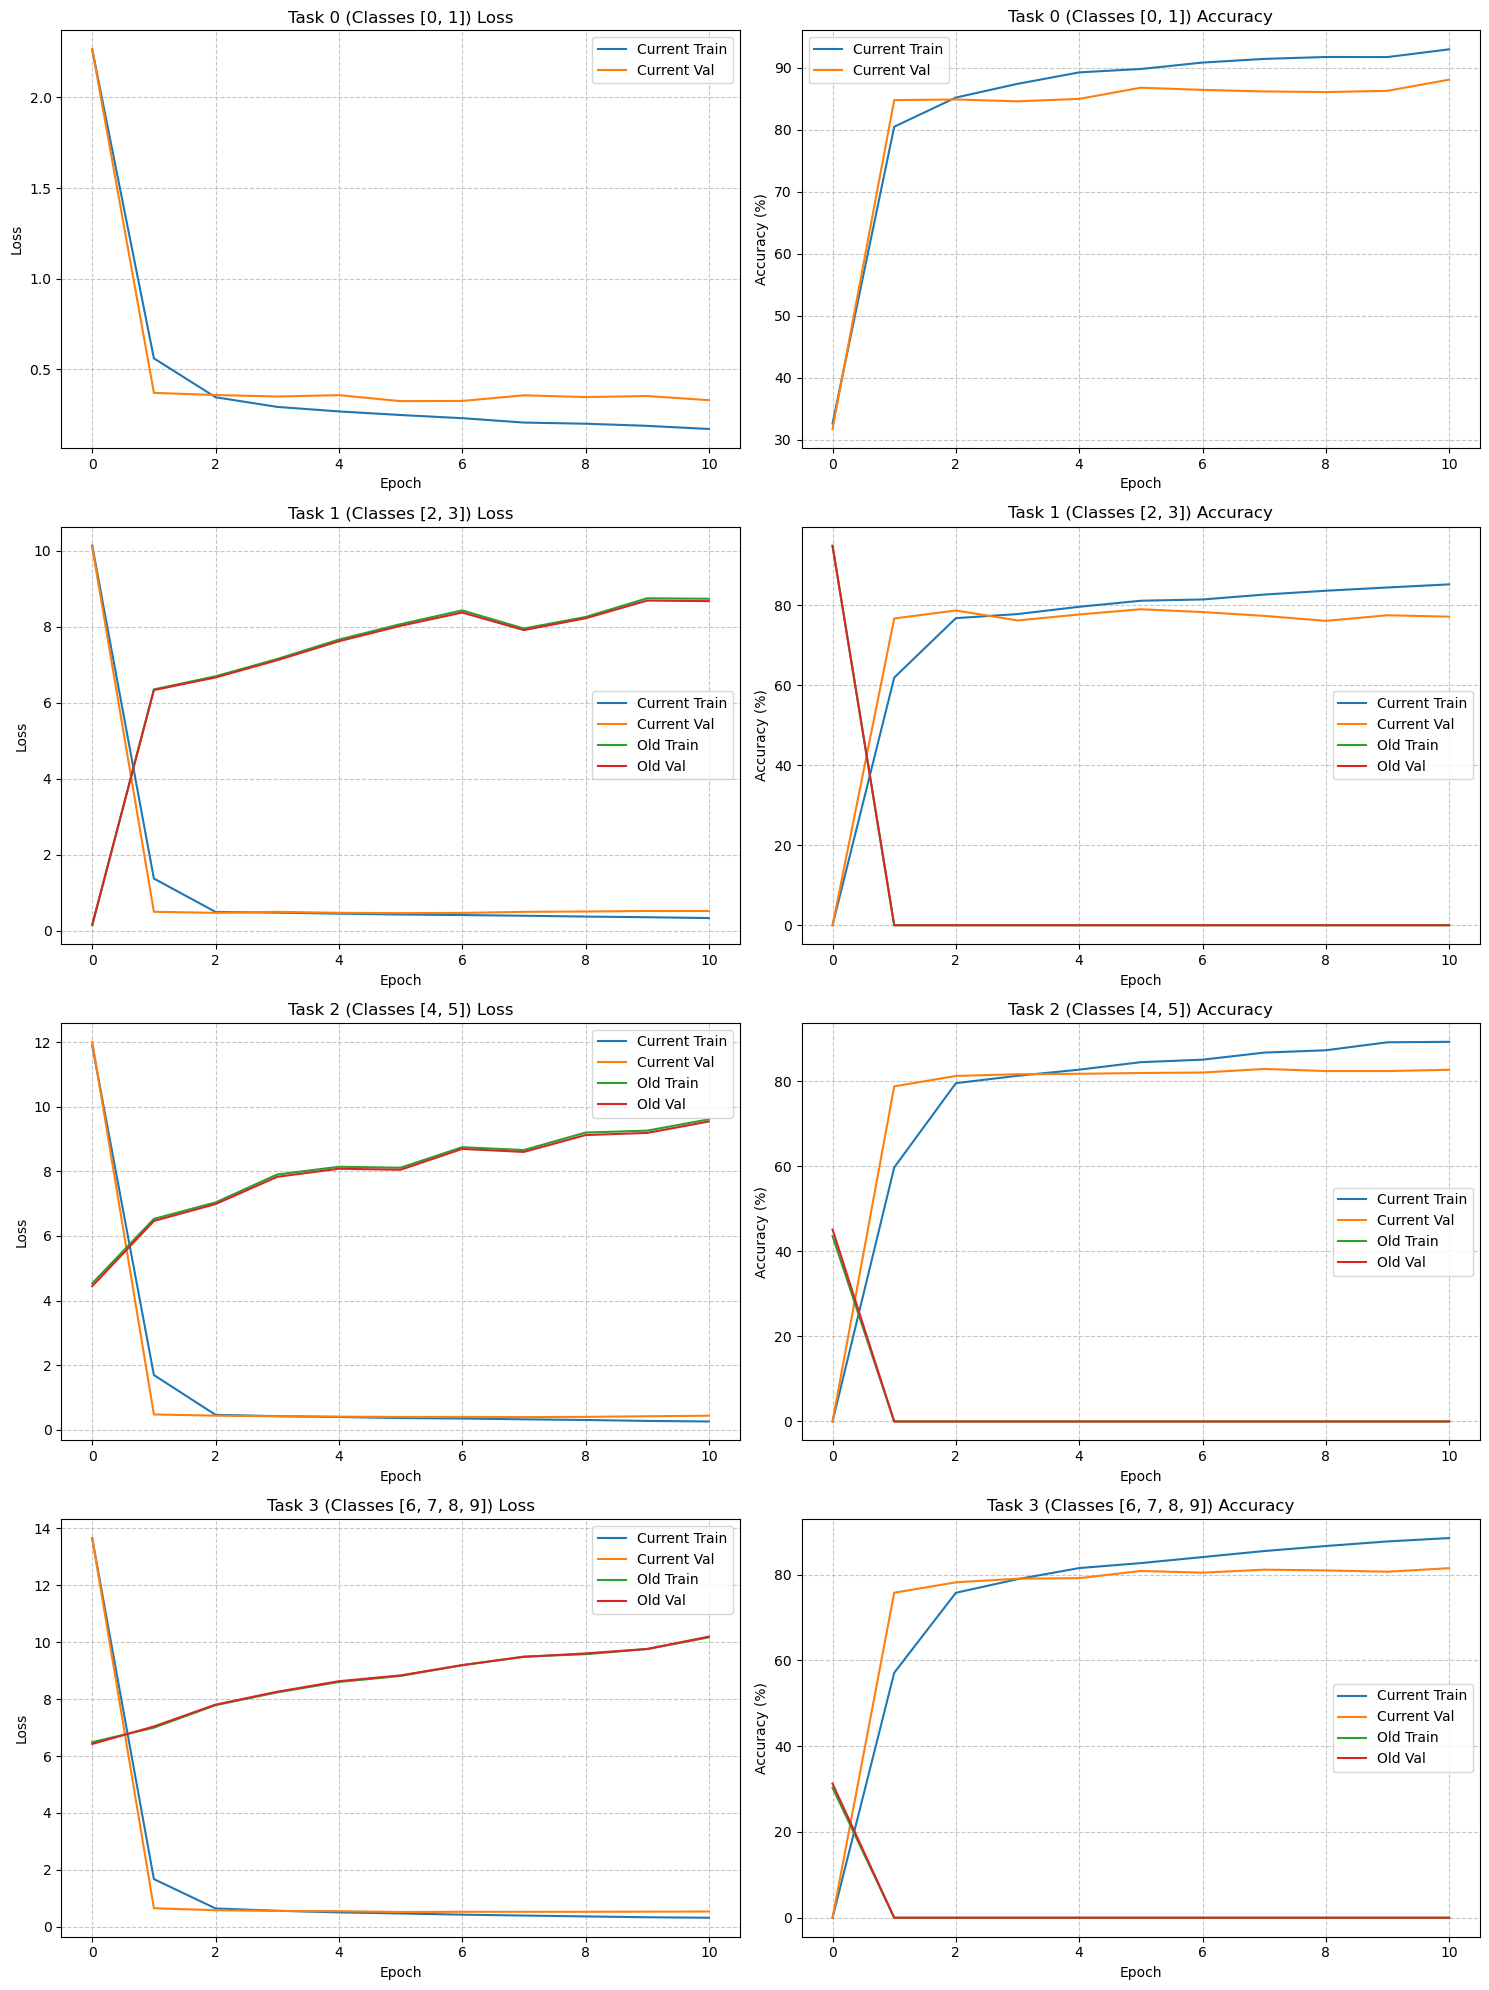

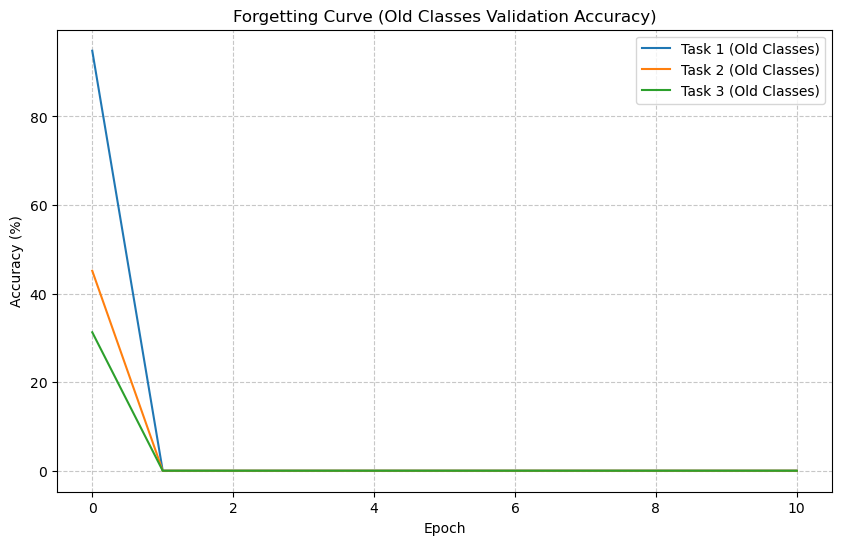

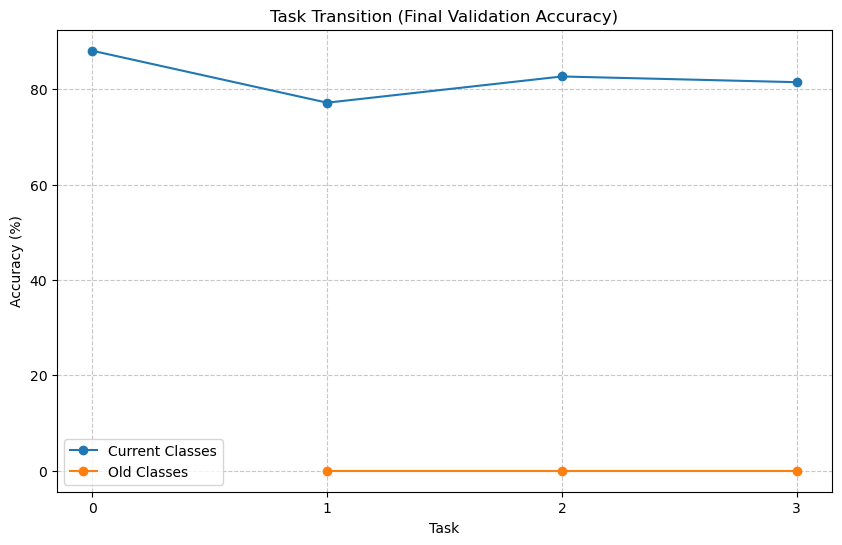


Experiment completed!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
import wandb
from collections import defaultdict

# Import the necessary classes from the provided code
# MLP, CNN, ResNet, VisionTransformer, NetworkMonitor, etc. would be imported here
from continual_learning  import * 

###########################################
# Continual Learning Dataset Functions
###########################################

class SubsetDataset(Dataset):
    """Dataset wrapper for class subset selection"""
    def __init__(self, dataset, class_indices):
        self.dataset = dataset
        self.class_indices = class_indices
        self.indices = self._get_indices()
        
    def _get_indices(self):
        indices = []
        for i in range(len(self.dataset)):
            _, label = self.dataset[i]
            if label in self.class_indices:
                indices.append(i)
        return indices
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        # Map the original label to a new index if needed
        # This part can be modified to remap labels based on the continual learning strategy
        return image, label


def prepare_continual_learning_data(dataset, class_sequence, batch_size=128, val_split=0.2):
    """
    Prepare dataloaders for continual learning on a sequence of class subsets.
    
    Args:
        dataset: The full dataset (e.g., CIFAR10)
        class_sequence: List of lists, where each inner list contains class indices for a task
        batch_size: Batch size for dataloaders
        val_split: Fraction of data to use for validation
    
    Returns:
        Dictionary mapping task_id -> (train_loader, val_loader, fixed_train_loader, fixed_val_loader)
    """
    dataloaders = {}
    all_seen_classes = set()
    
    for task_id, classes in enumerate(class_sequence):
        current_classes = set(classes)
        
        # Create current task dataset
        current_dataset = SubsetDataset(dataset, classes)
        
        # Split into training and validation
        dataset_size = len(current_dataset)
        val_size = int(val_split * dataset_size)
        train_size = dataset_size - val_size
        
        indices = list(range(dataset_size))
        random.shuffle(indices)
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]
        
        train_subset = Subset(current_dataset, train_indices)
        val_subset = Subset(current_dataset, val_indices)
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
        
        # Fixed batches for metrics
        fixed_train = Subset(train_subset, range(min(500, len(train_subset))))
        fixed_val = Subset(val_subset, range(min(500, len(val_subset))))
        
        fixed_train_loader = DataLoader(fixed_train, batch_size=batch_size, shuffle=False)
        fixed_val_loader = DataLoader(fixed_val, batch_size=batch_size, shuffle=False)
        
        # For previous tasks (old classes)
        old_loaders = {}
        if task_id > 0:
            old_classes = all_seen_classes - current_classes
            if old_classes:
                old_dataset = SubsetDataset(dataset, list(old_classes))
                old_size = len(old_dataset)
                old_indices = list(range(old_size))
                random.shuffle(old_indices)
                
                old_train_size = int((1 - val_split) * old_size)
                old_train_indices = old_indices[:old_train_size]
                old_val_indices = old_indices[old_train_size:]
                
                old_train_subset = Subset(old_dataset, old_train_indices)
                old_val_subset = Subset(old_dataset, old_val_indices)
                
                old_train_loader = DataLoader(old_train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
                old_val_loader = DataLoader(old_val_subset, batch_size=batch_size, shuffle=False, num_workers=2)
                
                # Fixed old batches for metrics
                fixed_old_train = Subset(old_train_subset, range(min(500, len(old_train_subset))))
                fixed_old_val = Subset(old_val_subset, range(min(500, len(old_val_subset))))
                
                fixed_old_train_loader = DataLoader(fixed_old_train, batch_size=batch_size, shuffle=False)
                fixed_old_val_loader = DataLoader(fixed_old_val, batch_size=batch_size, shuffle=False)
                
                old_loaders = {
                    'train': old_train_loader,
                    'val': old_val_loader,
                    'fixed_train': fixed_old_train_loader,
                    'fixed_val': fixed_old_val_loader
                }
        
        # Store the dataloaders for this task
        dataloaders[task_id] = {
            'current': {
                'train': train_loader,
                'val': val_loader,
                'fixed_train': fixed_train_loader,
                'fixed_val': fixed_val_loader,
                'classes': classes
            },
            'old': old_loaders
        }
        
        # Update the set of all seen classes
        all_seen_classes.update(current_classes)
    
    return dataloaders


def get_cifar10_continual_data(class_sequence, batch_size=128):
    """
    Get CIFAR10 data prepared for continual learning.
    
    Args:
        class_sequence: List of lists, where each inner list contains class indices for a task
        batch_size: Batch size for dataloaders
    
    Returns:
        Dictionary mapping task_id -> task data loaders
    """
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform_test)
    
    train_dataloaders = prepare_continual_learning_data(trainset, class_sequence, batch_size)
    test_dataloaders = prepare_continual_learning_data(testset, class_sequence, batch_size)
    
    return train_dataloaders, test_dataloaders


###########################################
# Continual Learning Training Functions
###########################################

def evaluate_model(model, dataloader, criterion, device='cpu'):
    """
    Evaluate model on a dataset.
    
    Returns:
        loss, accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    return running_loss / len(dataloader), 100. * correct / total


def train_continual_learning(model, task_dataloaders, config, device='cpu'):
    """
    Train a model using continual learning on a sequence of tasks.
    
    Args:
        model: The neural network model
        task_dataloaders: Dictionary mapping task_id -> task data loaders
        config: Configuration dictionary
        device: Device to train on
    
    Returns:
        Dictionary with training history
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
    
    # Create module filter function similar to the original code
    def module_filter(name):
        return 'linear' in name or '.mlp' in name or 'fc' in name or name.endswith('.proj')
    
    # For monitoring metrics
    train_monitor = NetworkMonitor(model, module_filter)
    val_monitor = NetworkMonitor(model, module_filter)
    
    # History tracking
    history = {
        'tasks': {}
    }
    
    print(f"Starting continual learning with {len(task_dataloaders)} tasks...")
    
    for task_id, task_data in task_dataloaders.items():
        print(f"\n{'='*50}")
        print(f"Starting Task {task_id}: Classes {task_data['current']['classes']}")
        print(f"{'='*50}")
        
        current_train_loader = task_data['current']['train']
        current_val_loader = task_data['current']['val']
        current_fixed_train = task_data['current']['fixed_train']
        current_fixed_val = task_data['current']['fixed_val']
        
        task_history = {
            'epochs': [],
            'current': {
                'train_loss': [],
                'train_acc': [],
                'val_loss': [],
                'val_acc': []
            },
            'old': {
                'train_loss': [],
                'train_acc': [],
                'val_loss': [],
                'val_acc': []
            },
            'training_metrics_history': defaultdict(lambda: defaultdict(list)),
            'validation_metrics_history': defaultdict(lambda: defaultdict(list))
        }
        
        # Get a fixed batch for metrics
        try:
            fixed_train_batch, fixed_train_targets = next(iter(current_fixed_train))
            fixed_val_batch, fixed_val_targets = next(iter(current_fixed_val))
            
            fixed_train_batch = fixed_train_batch.to(device)
            fixed_train_targets = fixed_train_targets.to(device)
            fixed_val_batch = fixed_val_batch.to(device)
            fixed_val_targets = fixed_val_targets.to(device)
            
            # Initial metrics
            print("Measuring initial metrics...")
            
            train_metrics = analyze_fixed_batch(model, train_monitor, fixed_train_batch, 
                                              fixed_train_targets, criterion, device=device)
            val_metrics = analyze_fixed_batch(model, val_monitor, fixed_val_batch, 
                                            fixed_val_targets, criterion, device=device)
            
            for layer_name, metrics in train_metrics.items():
                for metric_name, value in metrics.items():
                    task_history['training_metrics_history'][layer_name][metric_name].append(value)
            
            for layer_name, metrics in val_metrics.items():
                for metric_name, value in metrics.items():
                    task_history['validation_metrics_history'][layer_name][metric_name].append(value)
        except StopIteration:
            print("Warning: Not enough samples for fixed batch metrics")
        
        # If there are old classes (previous tasks)
        has_old_data = 'old' in task_data and task_data['old']
        if has_old_data:
            old_train_loader = task_data['old']['train']
            old_val_loader = task_data['old']['val']
            
            # Evaluate on old data before training on new data
            old_train_loss, old_train_acc = evaluate_model(model, old_train_loader, criterion, device)
            old_val_loss, old_val_acc = evaluate_model(model, old_val_loader, criterion, device)
            
            print(f"Initial performance on OLD classes:")
            print(f"  Train Loss: {old_train_loss:.4f}, Train Acc: {old_train_acc:.2f}%")
            print(f"  Val Loss: {old_val_loss:.4f}, Val Acc: {old_val_acc:.2f}%")
        
        # Evaluate on current task before training
        current_train_loss, current_train_acc = evaluate_model(model, current_train_loader, criterion, device)
        current_val_loss, current_val_acc = evaluate_model(model, current_val_loader, criterion, device)
        
        print(f"Initial performance on CURRENT classes:")
        print(f"  Train Loss: {current_train_loss:.4f}, Train Acc: {current_train_acc:.2f}%")
        print(f"  Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.2f}%")
        
        # Record initial metrics
        task_history['epochs'].append(0)
        task_history['current']['train_loss'].append(current_train_loss)
        task_history['current']['train_acc'].append(current_train_acc)
        task_history['current']['val_loss'].append(current_val_loss)
        task_history['current']['val_acc'].append(current_val_acc)
        
        if has_old_data:
            task_history['old']['train_loss'].append(old_train_loss)
            task_history['old']['train_acc'].append(old_train_acc)
            task_history['old']['val_loss'].append(old_val_loss)
            task_history['old']['val_acc'].append(old_val_acc)
        
        # Training loop for this task
        start_time = time.time()
        for epoch in range(1, config["epochs_per_task"] + 1):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, targets in current_train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            epoch_train_loss = running_loss / len(current_train_loader)
            epoch_train_acc = 100. * correct / total
            
            # Evaluate on current task
            current_val_loss, current_val_acc = evaluate_model(model, current_val_loader, criterion, device)
            
            # Record current task metrics
            task_history['epochs'].append(epoch)
            task_history['current']['train_loss'].append(epoch_train_loss)
            task_history['current']['train_acc'].append(epoch_train_acc)
            task_history['current']['val_loss'].append(current_val_loss)
            task_history['current']['val_acc'].append(current_val_acc)
            
            # If there are old classes, evaluate on them too
            if has_old_data:
                old_train_loss, old_train_acc = evaluate_model(model, old_train_loader, criterion, device)
                old_val_loss, old_val_acc = evaluate_model(model, old_val_loader, criterion, device)
                
                task_history['old']['train_loss'].append(old_train_loss)
                task_history['old']['train_acc'].append(old_train_acc)
                task_history['old']['val_loss'].append(old_val_loss)
                task_history['old']['val_acc'].append(old_val_acc)
            
            # Periodically collect network metrics
            if epoch % config["metrics_frequency"] == 0 or epoch == config["epochs_per_task"]:
                try:
                    train_monitor.clear_data()
                    val_monitor.clear_data()
                    
                    # Analyze current fixed batches
                    train_metrics = analyze_fixed_batch(model, train_monitor, fixed_train_batch, 
                                                      fixed_train_targets, criterion, 
                                                      dead_threshold=0.95, 
                                                      corr_threshold=0.99, 
                                                      saturation_threshold=1e-6,
                                                      saturation_percentage=0.99,
                                                      device=device)
                    val_metrics = analyze_fixed_batch(model, val_monitor, fixed_val_batch, 
                                                    fixed_val_targets, criterion, 
                                                    dead_threshold=0.95, 
                                                    corr_threshold=0.99, 
                                                    saturation_threshold=1e-6,
                                                    saturation_percentage=0.99,
                                                    device=device)
                    
                    # Log current fixed batch metrics to wandb
                    fixed_metrics_log = {"task": task_id, "epoch": epoch}
                    for layer_name, metrics in train_metrics.items():
                        for metric_name, value in metrics.items():
                            fixed_metrics_log[f"current_fixed_train/{layer_name}/{metric_name}"] = value
                    for layer_name, metrics in val_metrics.items():
                        for metric_name, value in metrics.items():
                            fixed_metrics_log[f"current_fixed_val/{layer_name}/{metric_name}"] = value
                    
                    # Log old fixed batch metrics if available
                    if has_old_data and 'fixed_train' in task_data['old'] and 'fixed_val' in task_data['old']:
                        try:
                            old_fixed_train = task_data['old']['fixed_train']
                            old_fixed_val = task_data['old']['fixed_val']
                            
                            old_fixed_train_batch, old_fixed_train_targets = next(iter(old_fixed_train))
                            old_fixed_val_batch, old_fixed_val_targets = next(iter(old_fixed_val))
                            
                            old_fixed_train_batch = old_fixed_train_batch.to(device)
                            old_fixed_train_targets = old_fixed_train_targets.to(device)
                            old_fixed_val_batch = old_fixed_val_batch.to(device)
                            old_fixed_val_targets = old_fixed_val_targets.to(device)
                            
                            # Clear monitors
                            train_monitor.clear_data()
                            val_monitor.clear_data()
                            
                            # Analyze old fixed batches
                            old_train_metrics = analyze_fixed_batch(model, train_monitor, old_fixed_train_batch, 
                                                                old_fixed_train_targets, criterion, 
                                                                dead_threshold=0.95, 
                                                                corr_threshold=0.99, 
                                                                saturation_threshold=1e-6,
                                                                saturation_percentage=0.99,
                                                                device=device)
                            old_val_metrics = analyze_fixed_batch(model, val_monitor, old_fixed_val_batch, 
                                                              old_fixed_val_targets, criterion, 
                                                              dead_threshold=0.95, 
                                                              corr_threshold=0.99, 
                                                              saturation_threshold=1e-6,
                                                              saturation_percentage=0.99,
                                                              device=device)
                            
                            # Log old fixed batch metrics to wandb
                            for layer_name, metrics in old_train_metrics.items():
                                for metric_name, value in metrics.items():
                                    fixed_metrics_log[f"old_fixed_train/{layer_name}/{metric_name}"] = value
                            for layer_name, metrics in old_val_metrics.items():
                                for metric_name, value in metrics.items():
                                    fixed_metrics_log[f"old_fixed_val/{layer_name}/{metric_name}"] = value
                        except Exception as e:
                            print(f"Error collecting old fixed batch metrics: {e}")
                    
                    # Log all metrics to wandb
                    wandb.log(fixed_metrics_log)
                    
                    # Store metrics in history for later analysis
                    for layer_name, metrics in train_metrics.items():
                        for metric_name, value in metrics.items():
                            task_history['training_metrics_history'][layer_name][metric_name].append(value)
                    
                    for layer_name, metrics in val_metrics.items():
                        for metric_name, value in metrics.items():
                            task_history['validation_metrics_history'][layer_name][metric_name].append(value)
                except Exception as e:
                    print(f"Error collecting metrics: {e}")
            
            # Log to wandb
            log_data = {
                "task": task_id,
                "epoch": epoch,
                "current_train_loss": epoch_train_loss,
                "current_train_acc": epoch_train_acc,
                "current_val_loss": current_val_loss,
                "current_val_acc": current_val_acc
            }
            
            if has_old_data:
                log_data.update({
                    "old_train_loss": old_train_loss,
                    "old_train_acc": old_train_acc,
                    "old_val_loss": old_val_loss,
                    "old_val_acc": old_val_acc
                })
            
            wandb.log(log_data)
            
            # Print progress
            elapsed = time.time() - start_time
            print(f'Task {task_id}, Epoch {epoch}/{config["epochs_per_task"]}:')
            print(f'  CURRENT: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
                 f'Val Loss: {current_val_loss:.4f}, Val Acc: {current_val_acc:.2f}%')
            
            if has_old_data:
                print(f'  OLD: Train Loss: {old_train_loss:.4f}, Train Acc: {old_train_acc:.2f}%, '
                     f'Val Loss: {old_val_loss:.4f}, Val Acc: {old_val_acc:.2f}%')
            
            print(f'  Time: {elapsed:.2f}s')
        
        # Store task history
        history['tasks'][task_id] = {
            'classes': task_data['current']['classes'],
            'history': task_history
        }
        
        # Log task summary
        wandb.log({
            "task_completed": task_id,
            "final_current_train_acc": task_history['current']['train_acc'][-1],
            "final_current_val_acc": task_history['current']['val_acc'][-1],
            "elapsed_time": time.time() - start_time
        })
        
        if has_old_data:
            wandb.log({
                "final_old_train_acc": task_history['old']['train_acc'][-1],
                "final_old_val_acc": task_history['old']['val_acc'][-1],
            })
    
    return history


###########################################
# Visualization Functions
###########################################

def plot_continual_learning_curves(history, save_path=None):
    """
    Plot learning curves for continual learning experiment.
    """
    num_tasks = len(history['tasks'])
    fig, axs = plt.subplots(num_tasks, 2, figsize=(15, 5 * num_tasks))
    
    if num_tasks == 1:
        axs = np.array([axs])
    
    for task_id, task_data in history['tasks'].items():
        task_history = task_data['history']
        classes = task_data['classes']
        
        # Loss plot
        ax = axs[task_id, 0]
        ax.plot(task_history['epochs'], task_history['current']['train_loss'], label='Current Train')
        ax.plot(task_history['epochs'], task_history['current']['val_loss'], label='Current Val')
        
        if 'old' in task_history and task_history['old']['train_loss']:
            ax.plot(task_history['epochs'], task_history['old']['train_loss'], label='Old Train')
            ax.plot(task_history['epochs'], task_history['old']['val_loss'], label='Old Val')
        
        ax.set_title(f'Task {task_id} (Classes {classes}) Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Accuracy plot
        ax = axs[task_id, 1]
        ax.plot(task_history['epochs'], task_history['current']['train_acc'], label='Current Train')
        ax.plot(task_history['epochs'], task_history['current']['val_acc'], label='Current Val')
        
        if 'old' in task_history and task_history['old']['train_acc']:
            ax.plot(task_history['epochs'], task_history['old']['train_acc'], label='Old Train')
            ax.plot(task_history['epochs'], task_history['old']['val_acc'], label='Old Val')
        
        ax.set_title(f'Task {task_id} (Classes {classes}) Accuracy')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f"{save_path}/continual_learning_curves.png", dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_forgetting_curve(history, save_path=None):
    """
    Plot forgetting curve for old tasks as training progresses.
    """
    num_tasks = len(history['tasks'])
    
    if num_tasks <= 1:
        print("Need at least 2 tasks to plot forgetting curve")
        return
    
    plt.figure(figsize=(10, 6))
    
    # For each task, plot old validation accuracy
    for task_id in range(1, num_tasks):
        task_data = history['tasks'][task_id]
        task_history = task_data['history']
        
        if 'old' in task_history and task_history['old']['val_acc']:
            plt.plot(task_history['epochs'], task_history['old']['val_acc'], 
                     label=f'Task {task_id} (Old Classes)')
    
    plt.title('Forgetting Curve (Old Classes Validation Accuracy)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if save_path:
        plt.savefig(f"{save_path}/forgetting_curve.png", dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_task_transition(history, save_path=None):
    """
    Plot accuracy transitions between tasks.
    """
    num_tasks = len(history['tasks'])
    
    if num_tasks <= 1:
        print("Need at least 2 tasks to plot task transition")
        return
    
    # Extract final accuracies for each task
    current_val_acc = []
    old_val_acc = []
    
    for task_id in range(num_tasks):
        task_data = history['tasks'][task_id]
        task_history = task_data['history']
        
        current_val_acc.append(task_history['current']['val_acc'][-1])
        
        if task_id > 0 and 'old' in task_history and task_history['old']['val_acc']:
            old_val_acc.append(task_history['old']['val_acc'][-1])
    
    plt.figure(figsize=(10, 6))
    
    # Plot current validation accuracy
    plt.plot(range(num_tasks), current_val_acc, 'o-', label='Current Classes')
    
    # Plot old validation accuracy
    if old_val_acc:
        plt.plot(range(1, num_tasks), old_val_acc, 'o-', label='Old Classes')
    
    plt.title('Task Transition (Final Validation Accuracy)')
    plt.xlabel('Task')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(num_tasks))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    if save_path:
        plt.savefig(f"{save_path}/task_transition.png", dpi=300, bbox_inches='tight')
    
    plt.show()


###########################################
# Main Function
###########################################

if __name__ == "__main__":
    # Set random seed for reproducibility
    set_seed(42)
    
    # Configuration
    config = {
        "model_type": "MLP",  # Options: "MLP", "CNN", "ResNet", "VisionTransformer"
        "model_config": {
            "input_size": 3 * 32 * 32,
            "hidden_sizes": [512, 256, 128],
            "output_size": 10,  # Total number of classes in CIFAR10
            "activation": "relu",
            "dropout_p": 0.2,
            "normalization": "batch"
        },
        "learning_rate": 0.001,
        "batch_size": 64,
        "epochs_per_task": 10,
        "metrics_frequency": 2,
        "class_sequence": [
            [0, 1],      # Task 0: airplane, automobile
            [2, 3],      # Task 1: bird, cat
            [4, 5],      # Task 2: deer, dog
            [6, 7, 8, 9] # Task 3: frog, horse, ship, truck
        ]
    }
    
    # Initialize wandb
    wandb.init(project="continual-learning-cifar", config=config)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load data for continual learning
    print("Preparing CIFAR10 data for continual learning...")
    train_dataloaders, test_dataloaders = get_cifar10_continual_data(
        config["class_sequence"], 
        batch_size=config["batch_size"]
    )
    
    # Create model
    print(f"Creating {config['model_type']} model...")
    if config["model_type"] == "MLP":
        model = MLP(**config["model_config"])
    # Other model types can be added here
    
    model = model.to(device)
    
    # Print model architecture
    print("\nModel Architecture:")
    for name, module in model.named_modules():
        if len(name) > 0:
            print(f"{name}: {module.__class__.__name__}")
    
    # Run continual learning
    print("\nStarting continual learning experiment...")
    history = train_continual_learning(model, train_dataloaders, config, device)
    
    # Plot results
    results_dir = './results'
    os.makedirs(results_dir, exist_ok=True)
    
    print("\nPlotting results...")
    plot_continual_learning_curves(history, save_path=results_dir)
    plot_forgetting_curve(history, save_path=results_dir)
    plot_task_transition(history, save_path=results_dir)
    
    # Save results
    print("\nExperiment completed!")